## Pre-requisites / README

This section of the notebook contains the setup steps needed to execute the code. Follow the instructions in each cell of this section to ensure proper setup.

See https://github.com/mattsit/ICLUnstructuredData/ for complete usage instructions and the data.

In [1]:
# Import numpy as set the required random seed.
import numpy as np
np.random.seed(30224)
import matplotlib.pyplot as plt

In [2]:
# Click the "Choose Files" button below to
# upload all of the following data files into Google Colab:
# Data files available at https://github.com/mattsit/ICLUnstructuredData/

# - the Meta earnings call raw transcript files
#   (15 files)
#   (located under "meta_transcripts/" in the GitHub repo)
#   (source: copy+pasted from investors relations site from pdf to txt)

# - the Microsoft earnings call raw transcript files
#   (15 files)
#   (located under "microsoft_transcripts/" in the GitHub repo)
#   (source: downloaded from investors relations site and re-saved as txt)

# Total: 30 files to be uploaded

from google.colab import files
uploaded = files.upload()

Saving meta2020q1.txt to meta2020q1.txt
Saving meta2020q2.txt to meta2020q2.txt
Saving meta2020q3.txt to meta2020q3.txt
Saving meta2020q4.txt to meta2020q4.txt
Saving meta2021q1.txt to meta2021q1.txt
Saving meta2021q2.txt to meta2021q2.txt
Saving meta2021q3.txt to meta2021q3.txt
Saving meta2021q4.txt to meta2021q4.txt
Saving meta2022q1.txt to meta2022q1.txt
Saving meta2022q2.txt to meta2022q2.txt
Saving meta2022q3.txt to meta2022q3.txt
Saving meta2022q4.txt to meta2022q4.txt
Saving meta2023q1.txt to meta2023q1.txt
Saving meta2023q2.txt to meta2023q2.txt
Saving meta2023q3.txt to meta2023q3.txt
Saving TranscriptFY24Q1.txt to TranscriptFY24Q1.txt
Saving TranscriptFY23Q4.txt to TranscriptFY23Q4.txt
Saving TranscriptFY23Q3.txt to TranscriptFY23Q3.txt
Saving TranscriptFY23Q2.txt to TranscriptFY23Q2.txt
Saving TranscriptFY23Q1.txt to TranscriptFY23Q1.txt
Saving TranscriptFY22Q4.txt to TranscriptFY22Q4.txt
Saving TranscriptFY22Q3.txt to TranscriptFY22Q3.txt
Saving TranscriptFY22Q2.txt to Trans

In [3]:
# Installation of packages not available by default in fresh Colab runtimes.
!pip install textdescriptives
!pip install spacytextblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.3/254.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.3 MB/s eta 0:00:00
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41929 sha256=a5a1df419caa3f773c899f0b33305a68327339f473b117da4e34bebf404eb821
  Stored in directory: /root/.cache/pip/wheels/92/8e/16/c1e4d4d65685d71085e4e27b44d6ed880b0559474c9ee4ff66
Successfully built ftfy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


## Data preparation

This section includes all the data preparation before the problem statement can be addressed.

### Wrangling raw transcripts textual data

Loading the data, performing preliminary cleaning, and extracting out the different sections of the transcripts.

In [4]:
# Functions for parsing out the date of the earnings call from the transcript.

import re
import pandas as pd

def parse_alphabet_date(html):
  """Parses the date from an Alphabet earnings call webpage.

  Args:
    html: The html of the webpage.

  Returns:
    Pandas date of when the earnings call took place.
  """
  return pd.to_datetime(
      re.search(r'<div class="EventPage-date">(.*? 202\d)', html)
      .group(1)).date()


def parse_meta_date(text):
  """Parses the date from a Meta earnings call text.

  Args:
    text: The text of the raw transcript.

  Returns:
    Pandas date of when the earnings call took place.
  """
  # Should be in the header of the transcript
  try:
    # Some documents split the date over the 3rd and 4th lines.
    return pd.to_datetime(''.join(text.split('\n')[3:5]).replace(' ', '')).date()
  except:
    pass

  try:
    # Usually it is on the 3rd line.
    return pd.to_datetime(text.split('\n')[3].replace(' ', '')).date()
  except:
    # Try the 4th line, some documents have an extra line in the beginning.
    return pd.to_datetime(text.split('\n')[4].replace(' ', '')).date()

def parse_ms_date(text):
  """Parses the date from a Microsoft earnings call text.

  Args:
    text: The text of the raw transcript.

  Returns:
    Pandas date of when the earnings call took place.
  """
  # Should be in the header of the transcript
  return pd.to_datetime(text.split('\r')[2]).date()

In [5]:
# Functions for parsing out the prepared remarks of the earnings call from the transcript.

def parse_alphabet_prepared_remarks(html):
  """Extracts the prepared remarks from an Alphabet earnings call webpage.

  Args:
    html: The html of the webpage.

  Returns:
    String of the prepared remarks portion of the transcript.
  """
  return (re.sub(r'<\/?[a-z]>', ' ',  # Remove html tags
      # Until 2021 Q2, the operator was labeled as "Candice (Operator):".
      # After that, simply referred to as "Operator:".
      re.search(r'(Sundar Pichai, CEO (Alphabet and )?Google.*?)(Candice|Operator)', html)
      .group(1)
      .replace('â\x80\x99', '\''))  # Fix weird encoding of apostrophe
      .replace('  ', ' ')  # Fix double spaces
      .strip())

def parse_meta_prepared_remarks(text):
  """Extracts the prepared remarks from a Meta earnings call text.

  Args:
    text: The text of the raw transcript.

  Returns:
    String of the prepared remarks portion of the transcript.
  """
  return (re.sub(
      r'\n\d+\n', '\n',  # Remove page numbers, which appear on their own line.
      re.search(r'\n(Mark Zuckerberg, CEO\n[\S\s]*?)\nOperator:',
                    text, re.MULTILINE).group(1),
      re.MULTILINE)
      .replace('\n', ' ')
      .replace('  ', ' ')
      .strip())

def parse_ms_prepared_remarks(text):
  """Extracts the prepared remarks from a Microsoft earnings call text.

  Args:
    text: The text of the raw transcript.

  Returns:
    String of the prepared remarks portion of the transcript.
  """
  # In some quarters, the operator's words are left in the transcript.
  # In others, there are omitted with something to the effect of "(Operator direction.)".
  # In 2021 Q3, SATYA'S name was in title case for the prepared remarks, whereas usually it is in all caps.
  return (re.search(r'((SATYA NADELLA|Satya Nadella):.*?)(\([^\r]+ d?D?irection.\)|OPERATOR:)',
                    text.replace('\r', ' ').replace('  ', ' '))
      .group(1)
      .strip())

In [6]:
# Functions for parsing out the Q&A of the earnings call from the transcript.

def parse_alphabet_qna(html):
  """Extracts the Q&A from an Alphabet earnings call webpage.

  Args:
    html: The html of the webpage.

  Returns:
    List of tuples of strings of each (question, response) from the Q&A
    portion of the transcript.
  """
  # Until 2021 Q2, the operator was labeled as "Candice (Operator):".
  # After that, simply referred to as "Operator:".
  result = [(x[x.index('<b>'):]
             .replace('â\x80\x99', '\''))  # Fix weird encoding of apostrophe
            for x in re.split('Candice \(Operator\)|Operator', html)
            if '<b>' in x]
  if result[1].startswith('<b>Jim Friedland'):
    # Omit the first results which are the prepared remarks if
    # Jim Friedland (who is from Alphabet, not an analyst) talks first.
    result = result[2:]
  if result[-1].startswith('<b>Jim Friedland'):
    # Omit the last result which just closes the call if
    # Jim Friedland (who is from Alphabet, not an analyst) talks last.
    result = result[:-1]
  # Split out the question from the responses.
  result = [(x[:x.index('<b>', 1):], x[x.index('<b>', 1):]) for x in result]
  # Remove html tags.
  result = [(re.sub(r'<\/?[a-z]>', ' ', x)
             .replace('  ', ' ')  # Fix double spaces
             .strip(),
             re.sub(r'<\/?[a-z]>', ' ', y)
             .replace('  ', ' ')  # Fix double spaces
             .strip())
            for x, y in result]
  return result

def parse_meta_qna(text):
    """Extracts the Q&A from a Meta earnings call text.

    Args:
      text: The text of the raw transcript.

    Returns:
      List of tuples of strings of each (question, response) from the Q&A
      portion of the transcript.
    """
    result = []
    # Drop the first part which is the prepared remarks.
    # Drop the last part with the operator signing out.
    for r in text.split('Operator:')[1:-1]:
      r = r.strip()
      r = re.search(r'([A-Za-z ]+:[\S\s]*)', r, re.MULTILINE).group(1)
      # Remove page numbers, which appear on their own line.
      r = re.sub(r'\n\d+\n', '\n', r, re.MULTILINE)

      # In Q4 2021 and Q4 2020 there were technical difficulties during the call
      # in which the operator intervened before the question was answered.
      # If only one person spoke between operator dialogue, then merge it into
      # the previous exchange.
      try:
        response_start_index = re.search(r'\n([A-Za-z ]+:[\S\s]*)', r, re.MULTILINE).start()
      except AttributeError:
        result[-1] = (result[-1][0], result[-1][1] + ' ' + r)
        continue

      r = (r[:response_start_index]
           .replace('\n', ' ').replace('  ', ' ').strip(),
           r[response_start_index:]
           .replace('\n', ' ').replace('  ', ' ').strip())

      result.append(r)

    return result

def parse_ms_qna(text):
    """Extracts the Q&A from a Microsoft earnings call text.

    Args:
      text: The text of the raw transcript.

    Returns:
      List of tuples of strings of each (question, response) from the Q&A
      portion of the transcript.
    """
    result = []
    # In some quarters, the operator's words are left in the transcript.
    # In others, there are omitted with something to the effect of "(Operator direction.)".
    # Drop the first part which is the prepared remarks.
    # Drop the last part with the operator signing off.
    # In 2023 Q1, for half of the transcript neither annotation was used to
    # indicate the operator direction, thus must rely on Brett (a Microsoft speaker) calling on Joe (the operator for that call).
    for r in re.split(r'\([^\r]+ d?D?irection\.\)|OPERATOR:|BRETT IVERSEN:[^\r]+Joe[^\r]+', text)[1:-1]:
      try:
        r = re.search(r'(\r[A-Za-z, ]+:[\S\s]*)', r, re.MULTILINE).group(1)
      except AttributeError:
        continue

      response_start_index = re.search(r'\r([A-Za-z ]+:[\S\s]*)', r, re.MULTILINE).start()
      r = (r[:response_start_index]
           .replace('\n', ' ').replace('  ', ' ').strip(),
           r[response_start_index:]
           .replace('\n', ' ').replace('  ', ' ').strip())
      result.append(r)
    return result

In [7]:
# Putting together the Alphabet data set by dynamically loading the data
# from the source website using the requests module, and then applying
# the helper functions defined above to produce the analysis-ready data frame.

import requests

# Generates the date range that will serve as the index.
year_qtr_list = []
for year in range(2020, 2024):
  for qtr in range(1, 5):
    # Skip this quarter that has not been completed yet.
    if year == 2023 and qtr == 4:
      continue

    year_qtr_list.append((year, qtr))

alphabet = pd.DataFrame(year_qtr_list, columns=['year', 'qtr'])
alphabet.set_index(alphabet.apply(lambda x: f"{x['year']} Q{x['qtr']}", axis=1), inplace=True)

def generate_alphabet_url(year, qtr):
    """Generates the URL of the earnings call webpage.

    Note that in later quarters, some subdirectories are omitted from the URL.

    Returns:
      The URL string
    """
    if year < 2023 or year == 2023 and qtr == 1:
      maybeLegacySubdir = 'investor/events/'
    else:
      maybeLegacySubdir = ''
    return f'https://abc.xyz/{maybeLegacySubdir}{year}-q{qtr}-earnings-call/'

# Applies the above helper functions to extract out all the transcript sections.
alphabet['url'] = alphabet.apply(lambda x: generate_alphabet_url(x['year'], x['qtr']), axis=1)
alphabet['raw_transcript'] = alphabet.apply(lambda x: requests.get(x['url']).text, axis=1)
alphabet['date'] = alphabet.apply(lambda x: parse_alphabet_date(x['raw_transcript']), axis=1)
alphabet['prepared_remarks'] = alphabet.apply(lambda x: parse_alphabet_prepared_remarks(x['raw_transcript']), axis=1)
alphabet['q&a'] = alphabet.apply(lambda x: parse_alphabet_qna(x['raw_transcript']), axis=1)
alphabet['q'] = alphabet.apply(lambda x: [y[0] for y in x['q&a']], axis=1)
alphabet['a'] = alphabet.apply(lambda x: [y[1] for y in x['q&a']], axis=1)

# Preview examples
def preview_df_snippets(df):
  """Previews the data frame holding the extracted data for a company.

  Prints out for each quarter:
  - the beginning and end snippets of prepared remarks
  - the beginning and end snippets of each question and response

  """
  for i, row in df.iterrows():
    print(f"{row['year']} Q{df.loc[i, 'qtr']}")
    # Print the beginning and end of the prepared remarks string.
    # Should start with a greeting and end with a transition to Q&A.
    print('Prepared remarks:')
    print(row['prepared_remarks'][:75], '...', row['prepared_remarks'][-75:], sep='')
    # Print the beginning and end of each Q&A pair.
    # Should start with an analyst speaking and ends with a thank you.
    print('Q&A:')
    print('---')
    for j in range(len(row['q&a'])):
      print(row['q&a'][j][0][:75], '...', row['q&a'][j][0][-75:], sep='')
      print(row['q&a'][j][1][:75], '...', row['q&a'][j][1][-75:], sep='')
      print('---')
    print()

preview_df_snippets(alphabet)

alphabet

2020 Q1
Prepared remarks:
Sundar Pichai, CEO Alphabet and Google: Thank you, Jim, and good afternoon,...nter construction. Thank you and Sundar and I will now take your questions.
Q&A:
---
Eric Sheridan (UBS): Thanks for taking the question and hope all is safe an...ucture that you're reexamining as a result of the pandemic. Thanks so much.
Sundar Pichai, CEO Alphabet and Google: Eric, thanks. Thanks for the wishes... is an accentuation of where we were.  Eric Sheridan (UBS): Thanks so much.
---
Doug Anmuth (JP Morgan): Great. Thanks for taking the questions. One for Su...more disciplined or diligent on costs on the other side as well? Thank you.
Sundar Pichai, CEO Alphabet and Google: Thanks, Doug. It's a good question....r of investment is well managed.  Doug Anmuth (JP Morgan): Thank you, both.
---
Heather Bellini (Goldman Sachs): Great. Thank you so much for taking the qu...nd do you expect to have to do this again in the second quarter? Thank you.
Ruth Porat, CFO Alphabet and Goog

,year,qtr,url,raw_transcript,date,prepared_remarks,q&a,q,a
2020 Q1,2020,1,https://abc.xyz/investor/events/2020-q1-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2020-04-28,"Sundar Pichai, CEO Alphabet and Google: Thank ...",[(Eric Sheridan (UBS): Thanks for taking the q...,[Eric Sheridan (UBS): Thanks for taking the qu...,"[Sundar Pichai, CEO Alphabet and Google: Eric,..."
2020 Q2,2020,2,https://abc.xyz/investor/events/2020-q2-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2020-07-30,"Sundar Pichai, CEO Alphabet and Google: Thank ...",[(Eric Sheridan (UBS): Thank you for taking th...,[Eric Sheridan (UBS): Thank you for taking the...,"[Sundar Pichai, CEO Alphabet and Google: On Sh..."
2020 Q3,2020,3,https://abc.xyz/investor/events/2020-q3-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2020-10-29,"Sundar Pichai, CEO Alphabet and Google: Thank ...","[(Eric Sheridan (UBS): Question, maybe I can a...","[Eric Sheridan (UBS): Question, maybe I can as...","[Sundar Pichai, CEO Alphabet and Google: Thank..."
2020 Q4,2020,4,https://abc.xyz/investor/events/2020-q4-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2021-02-02,"Sundar Pichai, CEO Alphabet and Google: Thank ...",[(Eric Sheridan (UBS): Thank you so much for t...,[Eric Sheridan (UBS): Thank you so much for ta...,"[Sundar Pichai, CEO Alphabet and Google: On Cl..."
2021 Q1,2021,1,https://abc.xyz/investor/events/2021-q1-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2021-04-27,"Sundar Pichai, CEO Alphabet and Google : Thank...",[(Brian Nowak (Morgan Stanley): Thanks for tak...,[Brian Nowak (Morgan Stanley): Thanks for taki...,"[Sundar Pichai, CEO Alphabet and Google: Thank..."
2021 Q2,2021,2,https://abc.xyz/investor/events/2021-q2-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2021-07-27,"Sundar Pichai, CEO Alphabet and Google : Thank...","[(Brian Nowak, Morgan Stanley: Thanks for taki...","[Brian Nowak, Morgan Stanley: Thanks for takin...","[Sundar Pichai, CEO Alphabet and Google: Brian..."
2021 Q3,2021,3,https://abc.xyz/investor/events/2021-q3-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2021-10-26,"Sundar Pichai, CEO Alphabet and Google: Thank ...","[(Eric Sheridan, Goldman Sachs: Thank you very...","[Eric Sheridan, Goldman Sachs: Thank you very ...","[Sundar Pichai, CEO Alphabet and Google: Eric,..."
2021 Q4,2021,4,https://abc.xyz/investor/events/2021-q4-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2022-02-01,"Sundar Pichai, CEO Alphabet and Google: Thank ...","[(Doug Anmuth, JP Morgan: Thanks for taking th...","[Doug Anmuth, JP Morgan: Thanks for taking the...","[Sundar Pichai, CEO Alphabet and Google: Thank..."
2022 Q1,2022,1,https://abc.xyz/investor/events/2022-q1-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2022-04-26,"Sundar Pichai, CEO Alphabet and Google: Thank ...","[(Brian Nowak, Morgan Stanley: Thanks for taki...","[Brian Nowak, Morgan Stanley: Thanks for takin...","[Ruth Porat, CFO Alphabet and Google : Thanks,..."
2022 Q2,2022,2,https://abc.xyz/investor/events/2022-q2-earnin...,"<!DOCTYPE html>\n<html class=""EventPage"" lang=...",2022-07-26,"Sundar Pichai, CEO Alphabet and Google: Thank ...","[(Doug Anmuth, J.P. Morgan : Great. Thank you....","[Doug Anmuth, J.P. Morgan : Great. Thank you. ...","[Sundar Pichai, CEO Alphabet and Google: Thank..."


In [8]:
# Same as above, but for Meta, using the uploaded data files.

meta = pd.DataFrame(index=alphabet.index)
meta['year'] = alphabet['year']
meta['qtr'] = alphabet['qtr']
meta['filename'] = meta.apply(lambda x: f"meta{x['year']}q{x['qtr']}.txt", axis=1)
meta['raw_transcript'] = meta.apply(lambda x: open(x['filename'], 'rb').read().decode('utf-8'), axis=1)
meta['date'] = meta.apply(lambda x: parse_meta_date(x['raw_transcript']), axis=1)
meta['prepared_remarks'] = meta.apply(lambda x: parse_meta_prepared_remarks(x['raw_transcript']), axis=1)
meta['q&a'] = meta.apply(lambda x: parse_meta_qna(x['raw_transcript']), axis=1)
meta['q'] = meta.apply(lambda x: [y[0] for y in x['q&a']], axis=1)
meta['a'] = meta.apply(lambda x: [y[1] for y in x['q&a']], axis=1)

# Preview examples
preview_df_snippets(meta)
meta

2020 Q1
Prepared remarks:
Mark Zuckerberg, CEO Thanks everyone for joining us today. Before we get st...te these challenges. With that, Mike, let’s open the call for questions. 11
Q&A:
---
Brian Nowak: Thanks for taking my questions. I hope everyone is safe. I hav...o execute on to make the SMB offering more comprehensive in '21 and beyond.
David Wehner: Okay, Brian. Did you want to take that, Sheryl? Sheryl Sandbe...ll continue beyond that. David Wehner: Mike, we’ll go to the next question.
---
Douglas Anmuth: Great, thanks for taking the question. I have two, I think,...nslating into increased activity in the feed and Instagram Stories? Thanks.
Mark Zuckerberg: Sure. I can speak to the first one, and Dave can see if th...as Mark said, and that's creating supply on the ad impression side as well.
---
Justin Post: Great, thanks. Sheryl, maybe you could talk a little bit about...om direct response versus brand or maybe CPC bidding versus CPM? Thank you.
David Wehner: Sure, I can take th

,year,qtr,filename,raw_transcript,date,prepared_remarks,q&a,q,a
2020 Q1,2020,1,meta2020q1.txt,"1\nFacebook, Inc. (FB)\nFirst Quarter 2020 Res...",2020-04-29,"Mark Zuckerberg, CEO Thanks everyone for joini...",[(Brian Nowak: Thanks for taking my questions....,[Brian Nowak: Thanks for taking my questions. ...,"[David Wehner: Okay, Brian. Did you want to ta..."
2020 Q2,2020,2,meta2020q2.txt,"1\nFacebook, Inc. (FB)\nSecond Quarter 2020 Re...",2020-07-30,"Mark Zuckerberg, CEO Thanks everyone for joini...",[(Eric Sheridan: Thank you so much for taking ...,[Eric Sheridan: Thank you so much for taking t...,[Mark Zuckerberg: Sure. I can take the second ...
2020 Q3,2020,3,meta2020q3.txt,"1\nFacebook, Inc. (FB)\nThird Quarter 2020 Res...",2020-10-29,"Mark Zuckerberg, CEO Thanks everyone for joini...",[(Brian Nowak: Thanks for taking my question. ...,[Brian Nowak: Thanks for taking my question. I...,[Mark Zuckerberg: Sure. Thanks for the questio...
2020 Q4,2020,4,meta2020q4.txt,"1\nFacebook, Inc. (FB)\nFourth Quarter 2020 Re...",2021-01-27,"Mark Zuckerberg, CEO Thanks everyone for joini...",[(Brian Nowak: Thank for taking my question; I...,[Brian Nowak: Thank for taking my question; I ...,[Sheryl Sandberg: I can take the first. With I...
2021 Q1,2021,1,meta2021q1.txt,"1\nFacebook, Inc. (FB)\nFirst Quarter 2021 Res...",2021-04-28,"Mark Zuckerberg, CEO Hey everyone, thanks for ...",[(Brian Nowak: Thanks for taking my question. ...,[Brian Nowak: Thanks for taking my question. I...,[Sheryl Sandberg: I can start on the first. So...
2021 Q2,2021,2,meta2021q2.txt,"1\nFacebook, Inc. (FB)\nSecond Quarter 2021 Re...",2021-07-28,"Mark Zuckerberg, CEO Hi everyone. Thanks for j...",[(Brian Nowak: Thank for taking my questions. ...,[Brian Nowak: Thank for taking my questions. I...,[Mark Zuckerberg: Sure. I think I can probably...
2021 Q3,2021,3,meta2021q3.txt,"1\nFacebook, Inc. (FB)\nThird Quarter 2021 Res...",2021-10-25,"Mark Zuckerberg, CEO Hey everyone and thanks f...",[(Brian Nowak: Thanks for taking my questions....,[Brian Nowak: Thanks for taking my questions. ...,"[Dave Wehner: Yes. Sure, Brian. On Reels, that..."
2021 Q4,2021,4,meta2021q4.txt,"1\nMeta Platforms, Inc. (FB)\nFourth Quarter 2...",2022-02-02,"Mark Zuckerberg, CEO Hi everyone and thanks fo...",[(Brian Nowak: Thanks for taking my questions....,[Brian Nowak: Thanks for taking my questions. ...,"[Dave Wehner: Yes. Thanks, Brad. I can probabl..."
2022 Q1,2022,1,meta2022q1.txt,"1\nMeta Platforms, Inc. (FB)\nFirst Quarter 20...",2022-04-27,"Mark Zuckerberg, CEO Hey everyone, and thanks ...",[(Brian Nowak: Thanks for taking my questions....,[Brian Nowak: Thanks for taking my questions. ...,"[David Wehner: Hey Brian, I'll take a crack at..."
2022 Q2,2022,2,meta2022q2.txt,"1\nMeta Platforms, Inc. (META)\nSecond Quarter...",2022-07-27,"Mark Zuckerberg, CEO Hey everyone, thanks for ...",[(Brian Nowak: The first one around engagement...,[Brian Nowak: The first one around engagement ...,"[Dave Wehner: Yes. Brian, I can take both of t..."


In [9]:
# Same as above, but for Microsoft.

ms = pd.DataFrame(index=alphabet.index)
ms['year'] = alphabet['year']
ms['qtr'] = alphabet['qtr']
# Microsoft fiscal year is two quarters ahead of calendar year.
# Year bumps up if Q3 or Q4. Filenames only have last two digits of year.
# Quarter bumps up by 2, modulo 4 when quarters are zero-indexed.
ms['filename'] = ms.apply(
    lambda x: f"TranscriptFY{x['year']%100 if x['qtr'] <= 2 else (x['year']+1)%100}Q{(x['qtr']-1+2) % 4 + 1}.txt", axis=1)
ms['raw_transcript'] = ms.apply(lambda x: open(x['filename'], 'rb').read().decode('mac-roman'), axis=1)
ms['date'] = ms.apply(lambda x: parse_ms_date(x['raw_transcript']), axis=1)
ms['prepared_remarks'] = ms.apply(lambda x: parse_ms_prepared_remarks(x['raw_transcript']), axis=1)
ms['q&a'] = ms.apply(lambda x: parse_ms_qna(x['raw_transcript']), axis=1)
ms['q'] = ms.apply(lambda x: [y[0] for y in x['q&a']], axis=1)
ms['a'] = ms.apply(lambda x: [y[1] for y in x['q&a']], axis=1)

# Preview examples
preview_df_snippets(ms)
ms

2020 Q1
Prepared remarks:
SATYA NADELLA: Thank you, Mike. We delivered double-digit topline and botto...e only ask one question. Operator, can you please repeat your instructions.
Q&A:
---
KEITH WEISS, Morgan Stanley: Thank you, guys, for taking the question. Very...lationships with customers that you expect to pay out over a longer period?
SATYA NADELLA: Thank you, Keith, for the question. Overall, the perspective...SPENCER: Thanks, Keith. Operator, we'll take the next question now, please.
---
MARK MOERDLER, Bernstein Research: I apologize. Thank you for taking my que...w you deal with that on the Azure and the overall business side? Thank you.
MICHAEL SPENCER: Thanks, Mark. We'll take the next question, please.
---
HEATHER BELLINI, Goldman Sachs: Great, thank you so much for taking the que... of cloud adoption is increasing as a result of what's going on? Thank you.
SATYA NADELLA: Yeah, maybe, Amy, I'll take the second one first, and then y...PENCER: Thanks, Heather. Operator, we'll

,year,qtr,filename,raw_transcript,date,prepared_remarks,q&a,q,a
2020 Q1,2020,1,TranscriptFY20Q3.txt,Microsoft FY20 Third Quarter Earnings Conferen...,2020-04-29,"SATYA NADELLA: Thank you, Mike. We delivered d...","[(KEITH WEISS, Morgan Stanley: Thank you, guys...","[KEITH WEISS, Morgan Stanley: Thank you, guys,...","[SATYA NADELLA: Thank you, Keith, for the ques..."
2020 Q2,2020,2,TranscriptFY20Q4.txt,Microsoft FY20 Fourth Quarter Earnings Confere...,2020-07-22,"SATYA NADELLA: Thank you, Mike. We delivered r...","[(KEITH WEISS, Morgan Stanley: Excellent. Than...","[KEITH WEISS, Morgan Stanley: Excellent. Thank...","[SATYA NADELLA: Thank you, Keith, for the ques..."
2020 Q3,2020,3,TranscriptFY21Q1.txt,Microsoft FY21 First Quarter Earnings Conferen...,2020-10-27,"SATYA NADELLA: Thank you, Mike. We are off to ...","[(KEITH WEISS, Morgan Stanley: Excellent. Than...","[KEITH WEISS, Morgan Stanley: Excellent. Thank...","[SATYA NADELLA: Let me start, Keith. Thanks fo..."
2020 Q4,2020,4,TranscriptFY21Q2.txt,Microsoft FY21 Second Quarter Earnings Confere...,2021-01-26,"SATYA NADELLA: Thank you, Mike. It was a recor...","[(MARK MOERDLER, Bernstein Research: Thank you...","[MARK MOERDLER, Bernstein Research: Thank you ...","[SATYA NADELLA: Thanks, Mark. Maybe I’ll start..."
2021 Q1,2021,1,TranscriptFY21Q3.txt,Microsoft FY21 Third Quarter Earnings Conferen...,2021-04-27,"SATYA NADELLA: Thank you, Brett. It was a reco...","[(KEITH WEISS, Morgan Stanley: Excellent. Than...","[KEITH WEISS, Morgan Stanley: Excellent. Thank...","[SATYA NADELLA: Thank you, Keith, for the ques..."
2021 Q2,2021,2,TranscriptFY21Q4.txt,Microsoft FY21 Fourth Quarter Earnings Confere...,2021-07-27,"SATYA NADELLA: Thanks much, Brett. We had a ve...","[(KEITH WEISS, Morgan Stanley: Thank you for t...","[KEITH WEISS, Morgan Stanley: Thank you for ta...","[SATYA NADELLA: Thanks so much, Keith, for the..."
2021 Q3,2021,3,TranscriptFY22Q1.txt,Microsoft FY22 First Quarter Earnings Conferen...,2021-10-26,"Satya Nadella: Thank you, Brett. We are off t...","[(KEITH WEISS, Morgan Stanley: Excellent. Than...","[KEITH WEISS, Morgan Stanley: Excellent. Thank...","[SATYA NADELLA: Thank you so much, Keith, and ..."
2021 Q4,2021,4,TranscriptFY22Q2.txt,Microsoft FY22 Second Quarter Earnings Confere...,2022-01-25,"SATYA NADELLA: Thank you, Brett. It was a reco...","[(KEITH WEISS, Morgan Stanley: Excellent. Than...","[KEITH WEISS, Morgan Stanley: Excellent. Thank...","[SATYA NADELLA: Thank you, Keith. I’ll take th..."
2022 Q1,2022,1,TranscriptFY22Q3.txt,Microsoft FY22 Third Quarter Earnings Conferen...,2022-04-26,"SATYA NADELLA: Thank you, Brett. It was a reco...","[(KEITH WEISS, Morgan Stanley: Excellent. Than...","[KEITH WEISS, Morgan Stanley: Excellent. Thank...","[SATYA NADELLA: Yeah, maybe I’ll start. Maybe ..."
2022 Q2,2022,2,TranscriptFY22Q4.txt,Microsoft FY22 Fourth Quarter Earnings Confere...,2022-07-26,"SATYA NADELLA: Thank you, Brett. Amid this mac...","[(KEITH WEISS, Morgan Stanley: Excellent, than...","[KEITH WEISS, Morgan Stanley: Excellent, thank...","[SATYA NADELLA: Thank you, Keith, for the ques..."


### EDA Visualizations

The exploratory data analysis visualizations of the prepared data frames.

In [10]:
# Convenience dictionaries to store common colors and names,
# useful for plotting, particularly within a loop.

company_color = {
    'alphabet': 'tab:red',
    'meta': 'royalblue',
    'microsoft': 'forestgreen',
}

company_names_ordered = ['alphabet', 'meta', 'microsoft']
company_colors_ordered = [company_color[n] for n in company_names_ordered]

#### Fig 1

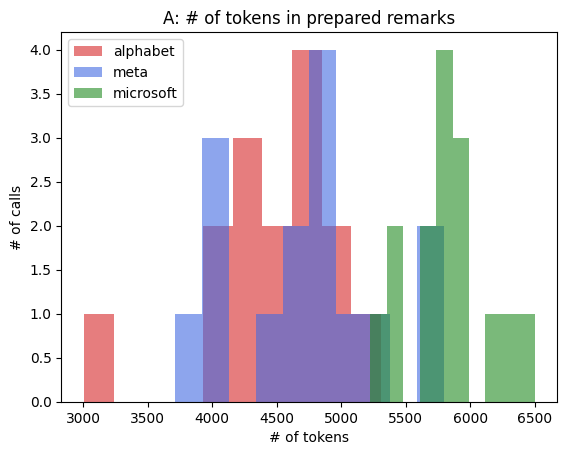

In [11]:
# --------------------#
#  GENERATES FIG 1A   #
# --------------------#

# Visualize the number of tokens in the prepared remarks of each call.

import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')

plt.hist(
    alphabet.apply(lambda x: len(nlp.tokenizer(x['prepared_remarks'])), axis=1),
    color=company_color['alphabet'], alpha=.6, label='alphabet')
plt.hist(
    meta.apply(lambda x: len(nlp.tokenizer(x['prepared_remarks'])), axis=1),
    color=company_color['meta'], alpha=.6, label='meta')
plt.hist(
    ms.apply(lambda x: len(nlp.tokenizer(x['prepared_remarks'])), axis=1),
    color=company_color['microsoft'], alpha=.6, label='microsoft')
plt.title('A: # of tokens in prepared remarks')
plt.xlabel('# of tokens')
plt.ylabel('# of calls')
plt.legend()
plt.show()

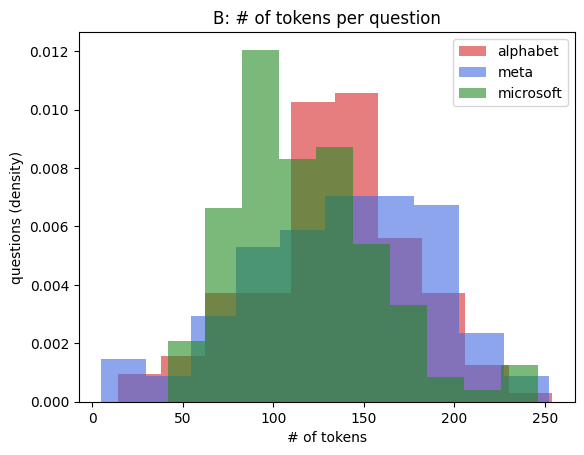

In [12]:
# --------------------#
#  GENERATES FIG 1B   #
# --------------------#

# Visualize the number of tokens in the analyst questions during each call.

alphabet_q_num_tokens = []
for x in alphabet.apply(lambda y: [len(nlp.tokenizer(z)) for z in y['q']], axis=1):
  alphabet_q_num_tokens.extend(x)
meta_q_num_tokens = []
for x in meta.apply(lambda y: [len(nlp.tokenizer(z)) for z in y['q']], axis=1):
  meta_q_num_tokens.extend(x)
ms_q_num_tokens = []
for x in ms.apply(lambda y: [len(nlp.tokenizer(z)) for z in y['q']], axis=1):
  ms_q_num_tokens.extend(x)

# Normalize with density plots since number of questions asked are not the same.
plt.hist(
    alphabet_q_num_tokens,
    color=company_color['alphabet'], alpha=.6, label='alphabet', density=True)
plt.hist(
    meta_q_num_tokens,
    color=company_color['meta'], alpha=.6, label='meta', density=True)
plt.hist(
    ms_q_num_tokens,
    color=company_color['microsoft'], alpha=.6, label='microsoft', density=True)
plt.title('B: # of tokens per question')
plt.xlabel('# of tokens')
plt.ylabel('questions (density)')
plt.legend()
plt.show()

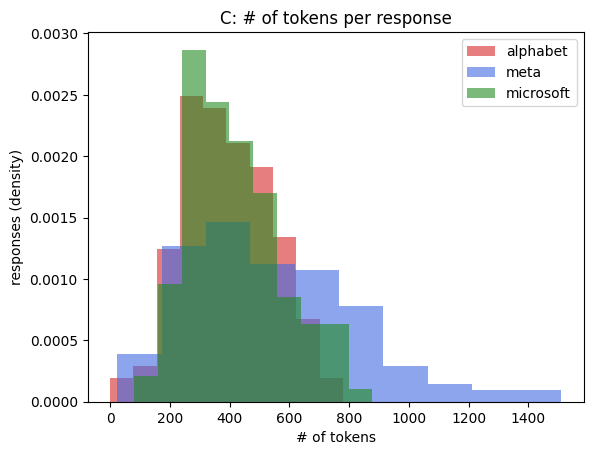

In [13]:
# --------------------#
#  GENERATES FIG 1C   #
# --------------------#

# Visualize the number of tokens in the Q&A responses during each call.

alphabet_a_num_tokens = []
for x in alphabet.apply(lambda y: [len(nlp.tokenizer(z)) for z in y['a']], axis=1):
  alphabet_a_num_tokens.extend(x)
meta_a_num_tokens = []
for x in meta.apply(lambda y: [len(nlp.tokenizer(z)) for z in y['a']], axis=1):
  meta_a_num_tokens.extend(x)
ms_a_num_tokens = []
for x in ms.apply(lambda y: [len(nlp.tokenizer(z)) for z in y['a']], axis=1):
  ms_a_num_tokens.extend(x)

# Normalize with density plots since number of questions asked are not the same.
plt.hist(
    alphabet_a_num_tokens,
    color=company_color['alphabet'], alpha=.6, label='alphabet', density=True)
plt.hist(
    meta_a_num_tokens,
    color=company_color['meta'], alpha=.6, label='meta', density=True)
plt.hist(
    ms_a_num_tokens,
    color=company_color['microsoft'], alpha=.6, label='microsoft', density=True)
plt.title('C: # of tokens per response')
plt.xlabel('# of tokens')
plt.ylabel('responses (density)')
plt.legend()
plt.show()

#### Fig 2

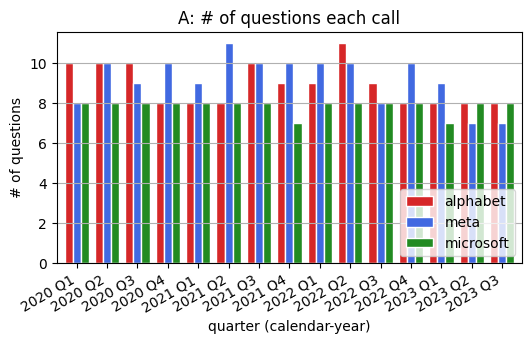

In [14]:
# --------------------#
#  GENERATES FIG 2A   #
# --------------------#

# Visualize the number of questions answered in each call.

num_q = pd.DataFrame(index=alphabet.apply(lambda x: f"{x['year']} Q{x['qtr']}", axis=1))
num_q['alphabet'] = alphabet.apply(lambda x: len(x['q&a']), axis=1)
num_q['meta'] = meta.apply(lambda x: len(x['q&a']), axis=1)
num_q['microsoft'] = ms.apply(lambda x: len(x['q&a']), axis=1)

num_q.plot.bar(figsize=(6,3), width=.8,
               color=company_colors_ordered, edgecolor='white')
plt.title('A: # of questions each call')
plt.xlabel('quarter (calendar-year)')
plt.ylabel('# of questions')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

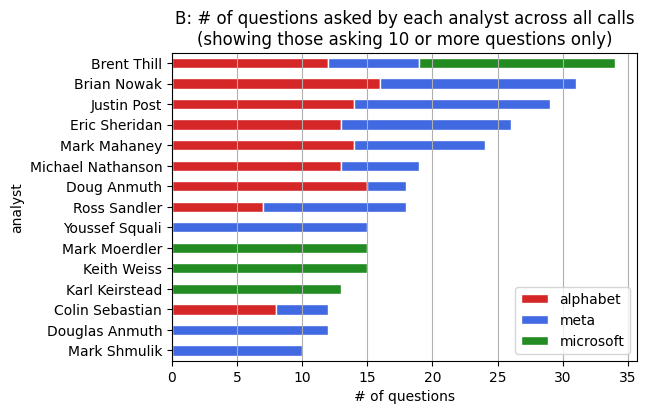

In [15]:
# --------------------#
#  GENERATES FIG 2B   #
# --------------------#

# Visualize the total number of questions asked by each analyst.

from collections import defaultdict

# Flatten lists of questions
alphabet_all_qna = []
for x in alphabet['q']:
  alphabet_all_qna.extend(x)

# Parse analyst who asked each question
# In some quarters, analyst affiliations were formatted as
# "Brian Nowak, Morgan Stanley:" vs.
# "Brian Nowak (Morgan Stanley):"
alphabet_analysts_question_count = defaultdict(int)
for x in alphabet_all_qna:
  name = re.split(r' \(|, ', x)[0].strip()
  alphabet_analysts_question_count[name] += 1

# Flatten lists of questions
meta_all_qna = []
for x in meta['q']:
  meta_all_qna.extend(x)

# Parse analyst who asked each question
meta_analysts_question_count = defaultdict(int)
for x in meta_all_qna:
  name = re.split(r' ?:', x)[0].strip()
  meta_analysts_question_count[name] += 1

# Flatten lists of questions
ms_all_qna = []
for x in ms['q']:
  ms_all_qna.extend(x)

# Parse analyst who asked each question
ms_analysts_question_count = defaultdict(int)
for x in ms_all_qna:
  name = re.split(r', ', x)[0].strip().title()
  ms_analysts_question_count[name] += 1

a, b = zip(*[(k, v) for k, v in alphabet_analysts_question_count.items()])
a2, b2 = zip(*[(k, v) for k, v in meta_analysts_question_count.items()])
a3, b3 = zip(*[(k, v) for k, v in ms_analysts_question_count.items()])
analysts_q_count = pd.DataFrame(b, index=a, columns=['alphabet'])
analysts_q_count = analysts_q_count.join(pd.DataFrame(b2, index=a2, columns=['meta']), how='outer')
analysts_q_count = analysts_q_count.join(pd.DataFrame(b3, index=a3, columns=['ms']), how='outer')
analysts_q_count = analysts_q_count.fillna(0)
analysts_q_count = analysts_q_count.astype(int)
# Sort by total number of questions asked by analysts across all companies.
analysts_q_count.sort_index(key=analysts_q_count.sum(1).get, ascending=False, inplace=True)
analysts_q_count.rename(columns={'ms': 'microsoft'}, inplace=True)
analysts_q_count = analysts_q_count[analysts_q_count.sum(axis=1) >= 10]

analysts_q_count.plot.barh(figsize=(6,4), width=.5, stacked=True,
                           color=company_colors_ordered, edgecolor='white')
plt.title('B: # of questions asked by each analyst across all calls\n(showing those asking 10 or more questions only)')
plt.xlabel('# of questions')
plt.ylabel('analyst')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

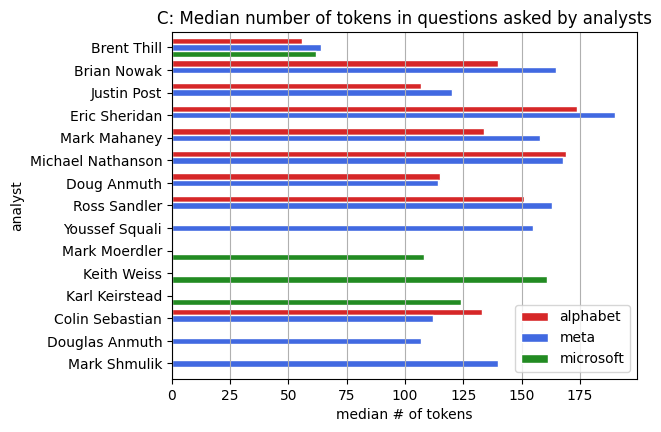

In [16]:
# --------------------#
#  GENERATES FIG 2C   #
# --------------------#

# Visualize the median number of tokens in questions asked by each analyst.

# Parse and separate analyst who asked each question and the question itself.
# Disregard their affiliation.
alphabet_analysts_question_tokens = defaultdict(list)
for x in alphabet_all_qna:
  name = re.split(r' \(|, ', x)[0].strip()
  question = x.split(':')[1]
  alphabet_analysts_question_tokens[name].append(len(nlp.tokenizer(question)))

# Parse and separate analyst who asked each question and the question itself.
# Disregard their affiliation.
meta_analysts_question_tokens = defaultdict(list)
for x in meta_all_qna:
  name = re.split(r' ?:', x)[0].strip()
  question = x.split(':')[1]
  meta_analysts_question_tokens[name].append(len(nlp.tokenizer(question)))

# Parse and separate analyst who asked each question and the question itself.
# Disregard their affiliation.
ms_analysts_question_tokens = defaultdict(list)
for x in ms_all_qna:
  name = re.split(r', ', x)[0].strip().title()
  question = x.split(':')[1]
  ms_analysts_question_tokens[name].append(len(nlp.tokenizer(question)))

a, b = zip(*[(k, np.median(v)) for k, v in alphabet_analysts_question_tokens.items()])
a2, b2 = zip(*[(k, np.median(v)) for k, v in meta_analysts_question_tokens.items()])
a3, b3 = zip(*[(k, np.median(v)) for k, v in ms_analysts_question_tokens.items()])
analysts_q_token_median = pd.DataFrame(index=analysts_q_count.index)
analysts_q_token_median = analysts_q_token_median.join(pd.DataFrame(b, index=a, columns=['alphabet']), how='left')
analysts_q_token_median = analysts_q_token_median.join(pd.DataFrame(b2, index=a2, columns=['meta']), how='left')
analysts_q_token_median = analysts_q_token_median.join(pd.DataFrame(b3, index=a3, columns=['ms']), how='left')
analysts_q_token_median = analysts_q_token_median.fillna(0)
analysts_q_token_median = analysts_q_token_median.astype(int)
analysts_q_token_median.rename(columns={'ms': 'microsoft'}, inplace=True)

analysts_q_token_median.plot.barh(figsize=(6,4.5), width=0.85,
                                  color=company_colors_ordered, edgecolor='white')
plt.title('C: Median number of tokens in questions asked by analysts')
plt.xlabel('median # of tokens')
plt.ylabel('analyst')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

#### Fig 3

In [17]:
# Add all needed modules to the spaCy pipeline and run it against all the data.

import textdescriptives as td
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
# https://spacy.io/universe/project/textdescriptives
nlp.add_pipe('textdescriptives/all')
# https://spacy.io/universe/project/spacy-textblob
# https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
nlp.add_pipe('spacytextblob')

# Organize results into a dictionary.
spacy_results = defaultdict(dict)
for company_name, company_df in [('alphabet', alphabet), ('meta', meta), ('microsoft', ms)]:
  for section in ['prepared_remarks', 'q', 'a']:
    spacy_results[company_name][section] = company_df.apply(lambda x: nlp(
        (' ' if len(section) == 1 else '').join(x[section])), axis=1)

/usr/local/lib/python3.10/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarities.append(sent.similarity(sents[i + order]))
/usr/local/lib/python3.10/dist-packages/textdescriptives/components/coherence.py:44: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with wo

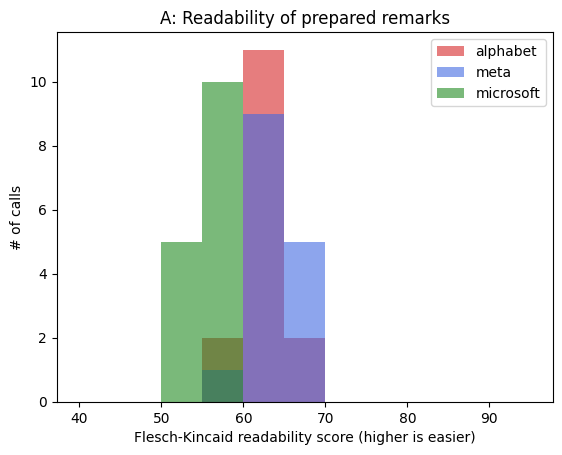

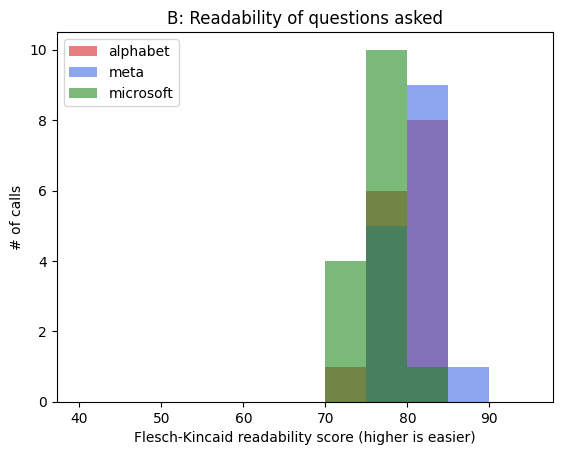

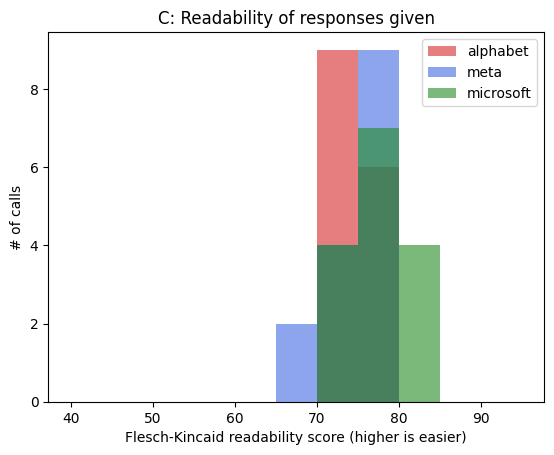

In [18]:
# --------------------#
#  GENERATES FIG 3A-C #
# --------------------#

# Visualize readibility scores between prepared remarks and Q&A segments.
# Ref: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

spacy_readabilities = defaultdict(dict)
for section in ['prepared_remarks', 'q', 'a']:
  for company_name in ['alphabet', 'meta', 'microsoft']:
    spacy_readabilities[company_name][section] = spacy_results[company_name][section].apply(
        lambda x: x._.readability['flesch_reading_ease'])
    plt.hist(
        spacy_readabilities[company_name][section],
        color=company_color[company_name],
        label=company_name,
        alpha=.6, bins=range(40, 100, 5))

  if section == 'prepared_remarks':
    plt.title('A: Readability of prepared remarks')
  elif section == 'q':
    plt.title('B: Readability of questions asked')
  else:
    plt.title('C: Readability of responses given')
  plt.xlabel('Flesch-Kincaid readability score (higher is easier)')
  plt.ylabel('# of calls')
  plt.legend()
  plt.show()

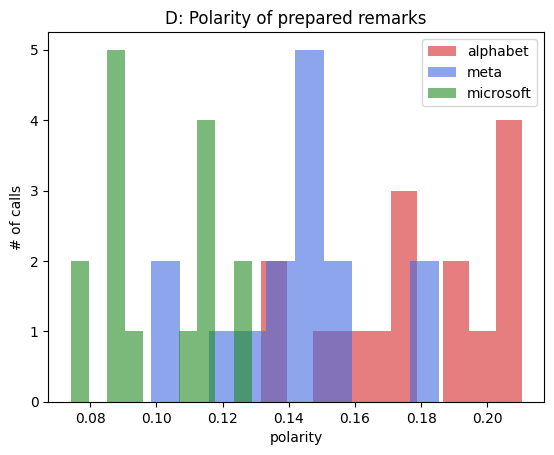

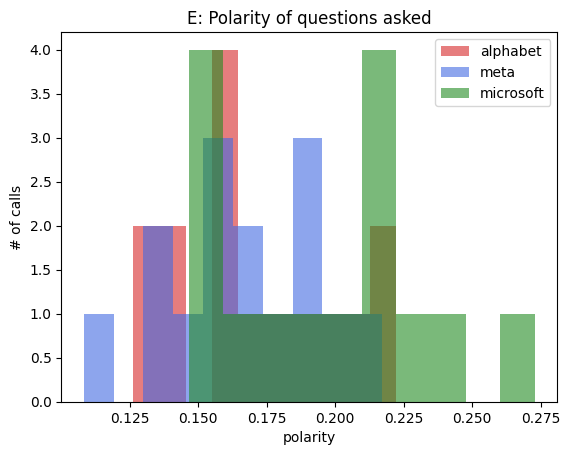

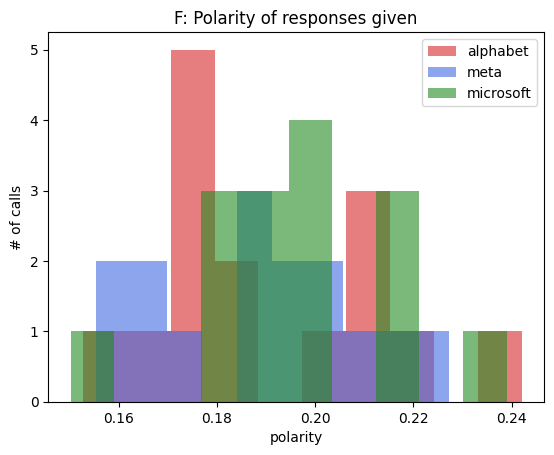

In [19]:
# --------------------#
#  GENERATES FIG 3D-F #
# --------------------#

# Visualize polarity scores between prepared remarks and Q&A segments.

spacy_polarities = defaultdict(dict)
for section in ['prepared_remarks', 'q', 'a']:
  for company_name in ['alphabet', 'meta', 'microsoft']:
    spacy_polarities[company_name][section] = spacy_results[company_name][section].apply(
        lambda x: x._.blob.polarity)
    plt.hist(
        spacy_polarities[company_name][section],
        color=company_color[company_name],
        label=company_name,
        alpha=.6)

  if section == 'prepared_remarks':
    plt.title('D: Polarity of prepared remarks')
  elif section == 'q':
    plt.title('E: Polarity of questions asked')
  else:
    plt.title('F: Polarity of responses given')
  plt.xlabel('polarity')
  plt.ylabel('# of calls')
  plt.legend()
  plt.show()

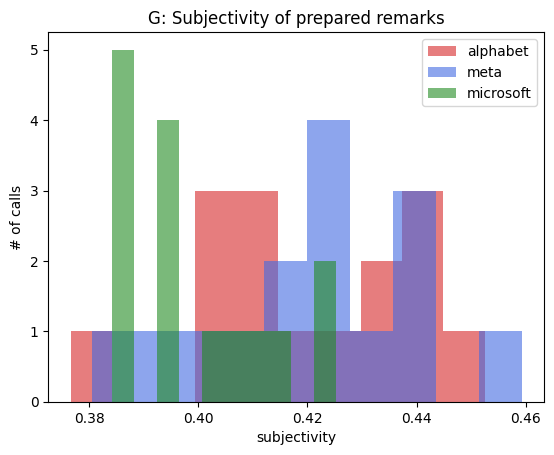

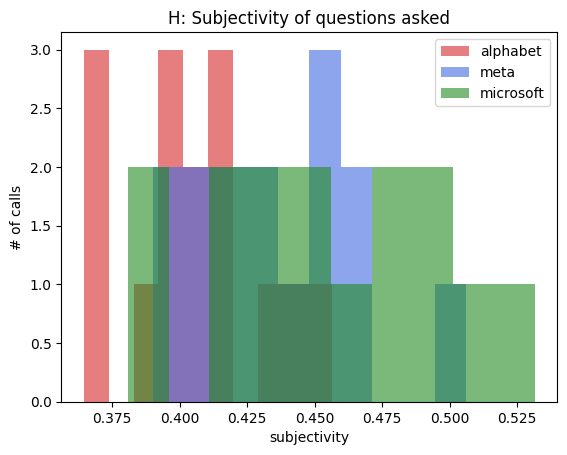

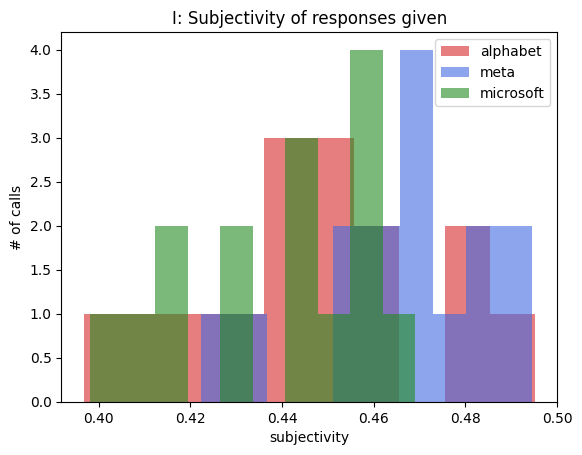

In [20]:
# --------------------#
#  GENERATES FIG 3G-I #
# --------------------#

# Visualize subjectivity scores between prepared remarks and Q&A segments.

spacy_subjectivities = defaultdict(dict)
for section in ['prepared_remarks', 'q', 'a']:
  for company_name in ['alphabet', 'meta', 'microsoft']:
    spacy_subjectivities[company_name][section] = spacy_results[company_name][section].apply(
        lambda x: x._.blob.subjectivity)
    plt.hist(
        spacy_subjectivities[company_name][section],
        color=company_color[company_name],
        label=company_name,
        alpha=.6)

  if section == 'prepared_remarks':
    plt.title('G: Subjectivity of prepared remarks')
  elif section == 'q':
    plt.title('H: Subjectivity of questions asked')
  else:
    plt.title('I: Subjectivity of responses given')
  plt.xlabel('subjectivity')
  plt.ylabel('# of calls')
  plt.legend()
  plt.show()

# Topic modeling

All code for the methods, analysis, and results.

## LSA on Prepared Remarks

### Textual data cleaning and embedding

In [21]:
# Define a helper function to perform all sentence cleaning steps.

nlp = spacy.load('en_core_web_sm')
def clean_tokens(text):
  """Applies all token cleaning steps.

  Filtering for valid tokens, removing standard English stop words, removing
  proper nouns, lemmatization, lower-casing, whitespace striping.

  Args:
    text: The text string of raw text to clean

  Returns:
    The cleaned string of tokens.
  """
  result = []
  for token in nlp(text.replace('-', ' ')):
    if (token.is_alpha and
        not token.is_stop and
        # Proper nouns are mostly names of people, products, or companies.
        # Eliminate them to encourage topics rather than names to be revealed.
        # Some common tech acronyms are considered as proper nouns by spaCy,
        # but are really spoken as nouns.
        (token.pos_ != 'PROPN' or token.text in ['AI', 'LLM', 'AR', 'ML', 'VR'])):
      result.append(token.lemma_.lower())
  return ' '.join(result).strip()

In [22]:
# Apply the cleaning function on all the prepared remarks.
prepared_remarks = []
prepared_remarks.extend(alphabet['prepared_remarks'].apply(clean_tokens))
prepared_remarks.extend(meta['prepared_remarks'].apply(clean_tokens))
prepared_remarks.extend(ms['prepared_remarks'].apply(clean_tokens))

#### Fig 4A, 4B

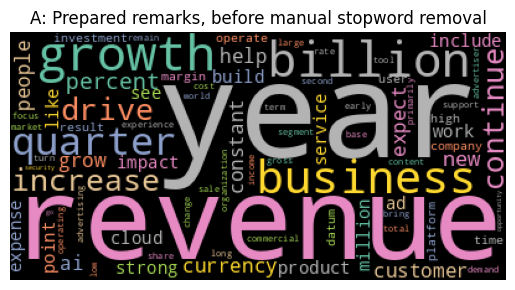

In [23]:
# --------------------#
#  GENERATES FIG 4A   #
# --------------------#

# Define a helper function to generate a word cloud for a data frame column.
# The purpose of that is to check for any dataset-specific stopwords that
# still need to be removed.

import wordcloud

def gen_wordcloud(lst_words, title):
  """Generates a word cloud visualization.

  Args:
    lst_words: List of strings of words.
    title: Plot title
  """
  wc = wordcloud.WordCloud(stopwords=set(), collocations=False, colormap='Set2', random_state=30224)
  wc.generate(' '.join(lst_words))
  plt.title(title)
  plt.imshow(wc)
  plt.axis('off')
  plt.show()

# Visualize to check for remaining stopwords among the prepared remarks.
gen_wordcloud(prepared_remarks, 'A: Prepared remarks, before manual stopword removal')

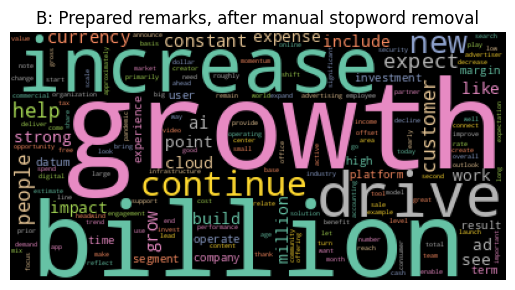

In [24]:
# --------------------#
#  GENERATES FIG 4B   #
# --------------------#

# Identified some finance-related stop words to remove.
financial_stopwords = ['revenue', 'year', 'quarter', 'business', 'percent', 'product', 'curency', 'service']
# Remove them.
for i in range(len(prepared_remarks)):
  for w in financial_stopwords:
    prepared_remarks[i] = prepared_remarks[i].replace(w, '')
# Check the word cloud again.
gen_wordcloud(prepared_remarks, 'B: Prepared remarks, after manual stopword removal')

### Performing LSA

Apply LSA on the cleaned prepared remarks data.

In [25]:
# Embed the prepared remarks using TF-IDF.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_prepared_remarks = vectorizer.fit_transform(prepared_remarks).T
tfidf_prepared_remarks.shape

(3632, 45)

In [26]:
# Take the SVD, as part of LSA.

U, S, Vt = np.linalg.svd(tfidf_prepared_remarks.todense())
U.shape, S.shape, Vt.shape

((3632, 3632), (45,), (45, 45))

#### Fig 5

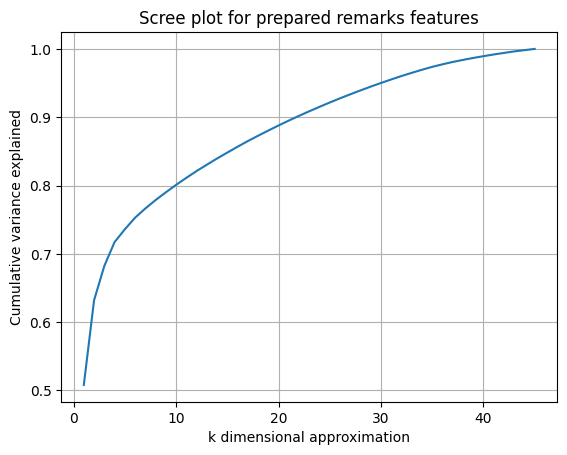

[0.50813385 0.63210983 0.68228639 0.71720847 0.73590401 0.75288594
 0.76639484 0.77872219 0.79004177 0.80095948 0.8112482  0.82119627
 0.83045545 0.83958609 0.84826229 0.85677214 0.8650799  0.87287733
 0.88047061 0.88792389 0.89511618 0.90202925 0.90873881 0.91522924
 0.92158811 0.92769748 0.93356925 0.93928229 0.94484706 0.95018073
 0.95532817 0.96033216 0.96500296 0.96950894 0.97376795 0.97748479
 0.98093496 0.98390881 0.98678711 0.98937363 0.9918611  0.99414344
 0.99636342 0.99821394 1.        ]


In [27]:
# --------------------#
#  GENERATES FIG 5    #
# --------------------#

# Plot a scree plot to visualize the number of dimensions vs
# the cumulative variance explained.

cum_var_explained = np.cumsum(S**2 / np.sum(S**2))

plt.plot(range(1, len(S)+1), cum_var_explained)
plt.title('Scree plot for prepared remarks features')
plt.xlabel('k dimensional approximation')
plt.ylabel('Cumulative variance explained')
plt.grid()
plt.show()
print(cum_var_explained)

### Examine the clusters
#### Fig 6

In [28]:
# --------------------#
#  GENERATES FIG 6    #
# --------------------#
# (which is the textual output)

# Helper functions to examine the clusters.
# Descriptions provided in the docstrings.
# Run these functions on the dimension-reduced LSA results based upon the elbow
# identified in the above scree plot.

def identify_transcript(idx):
  """Converts index to the corresponding transcript.

  The transcripts were stacked together in this order to create the combined
  data frame.

  Args:
    idx: Index of the transcript

  Returns:
  Name of the company and quarter/year of the corresponding transcript.
  """
  return ['alphabet', 'meta', 'microsoft'][idx//15] + ' ' + alphabet.index[idx % 15]

def show_topics(Uk, Sk, Vkt, vectorizer, show_docs=True):
  """Shows each of the topics produced by LSA.

  Sample terms and documents that were top contributors to the latent space representation.

  Args:
    Uk, Sk, Vkt: Dimension reduced SVD.
    vectorizer: The TfidfVectorizer that holds the vocabulary list.
    show_docs: Whether to print the top documents or not.
  """
  feature_index_to_vocab = [None] * len(vectorizer.vocabulary_)
  for k, v in vectorizer.vocabulary_.items():
      feature_index_to_vocab[v] = k

  for i in range(Sk.shape[0]):
      # Select top items based on magnitude.
      top_terms_indices = np.argsort(np.abs(np.asarray(Uk[:,i])).squeeze())[-8:][::-1]
      top_docs_indices = np.argsort(np.abs(np.asarray(Vkt[i])).squeeze())[-20:][::-1]
      if show_docs:
        print(f'--- TOPIC {i}: ---')
        # Signs reflect the direction of each top item.
        print(f'Top terms: {", ".join(feature_index_to_vocab[j] + ("-" if np.sign(Uk[j,i])<0 else "+") for j in top_terms_indices)}')
        print(f'Top docs: {", ".join([identify_transcript(top_docs_indices[j]) + ("-" if np.sign(Vkt[i,j])<0 else "+") for j in range(4)])}')
      else:
        print(f'Topic {i}: {", ".join(feature_index_to_vocab[j] for j in top_terms_indices)}')

def reduce_dims(U, S, Vt, k):
  """Returns the k-dimensional approximation.

  Args:
    U, S, Vt: The SVD
    k: # of dimensions desired

  Returns:
    Uk, Sk, Vkt
  """
  Uk = U[:,:k]
  Sk = S[:k]
  Vkt = Vt[:k,:]
  return Uk, Sk, Vkt

# There is an elbow here in the scree plot above.
# Reduce to k-dim approximation.
Uk, Sk, Vkt = reduce_dims(U, S, Vt, k=4)

# Apply above helper functions to describe the topics generated.
show_topics(Uk, Sk, Vkt, vectorizer)

--- TOPIC 0: ---
Top terms: growth-, billion-, drive-, increase-, continue-, new-, expect-, help-
Top docs: microsoft 2021 Q4-, microsoft 2023 Q1-, microsoft 2023 Q2-, microsoft 2021 Q1-
--- TOPIC 1: ---
Top terms: cloud+, constant+, currency+, gross+, ad-, people-, point+, increase+
Top docs: microsoft 2022 Q1-, microsoft 2022 Q3-, microsoft 2021 Q3-, microsoft 2021 Q2-
--- TOPIC 2: ---
Top terms: ad+, people+, go+, search-, reflect-, expect+, metaverse+, message+
Top docs: alphabet 2021 Q3-, alphabet 2022 Q3-, alphabet 2021 Q4-, alphabet 2020 Q3-
--- TOPIC 3: ---
Top terms: ai+, people-, help-, generative+, small-, pandemic-, cost+, crisis-
Top docs: meta 2020 Q1-, meta 2020 Q2-, meta 2023 Q3-, meta 2020 Q4-


### Query the LSA representation

In [29]:
# Helper function for executing a query against the LSA representation.

from sklearn.metrics.pairwise import cosine_similarity

def query_prepared_remarks(query, figlabel):
  query = clean_tokens(query)
  q = vectorizer.transform([query]).T
  # Embed the query into the latent space.
  # Refer to Eqn 1 in the report.
  q_embedded = np.diag(1/Sk) @ Uk.T @ q
  # Compute cosine similarities with each document in the latent space.
  similarities = cosine_similarity(np.asarray(q_embedded).T, np.asarray(Vkt).T).squeeze()

  # Plot the cosine similarities against the transcript dates.
  N = len(alphabet.index)
  for i in range(3):
    plt.plot(alphabet.index, similarities[i*N:(i+1)*N], color=company_colors_ordered[i], label=company_names_ordered[i])
  plt.title(f'{figlabel}: Query against prepared remarks:\n{query}')
  plt.xlabel('quarter (calendar-year)')
  plt.ylabel('cosine similarity')
  plt.xticks(rotation=30, ha='right')
  plt.grid(zorder=0)
  plt.legend()
  plt.show()

#### Fig 7

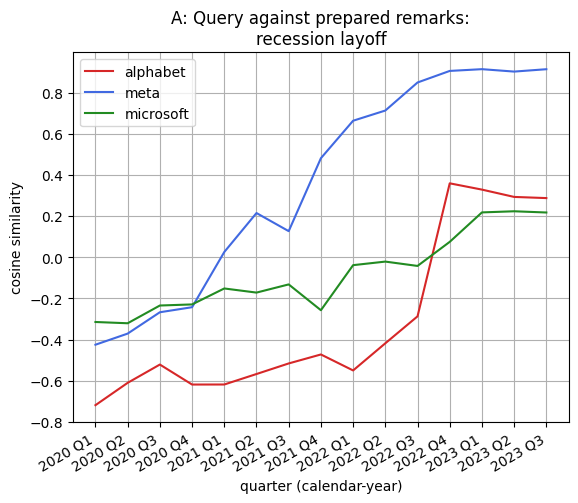

In [30]:
# --------------------#
#  GENERATES FIG 7A   #
# --------------------#

# Plot the trend of this query on the recession and industry layoffs.
query_prepared_remarks('recession layoff', 'A')

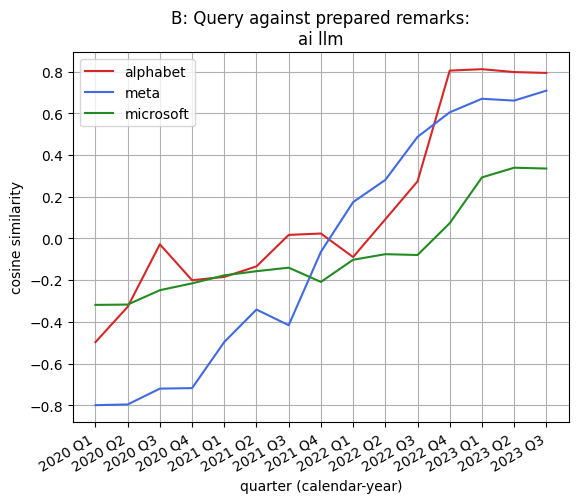

In [31]:
# --------------------#
#  GENERATES FIG 7B   #
# --------------------#

# Plot the trend of this query on AI and LLMs.
query_prepared_remarks('AI LLM', 'B')

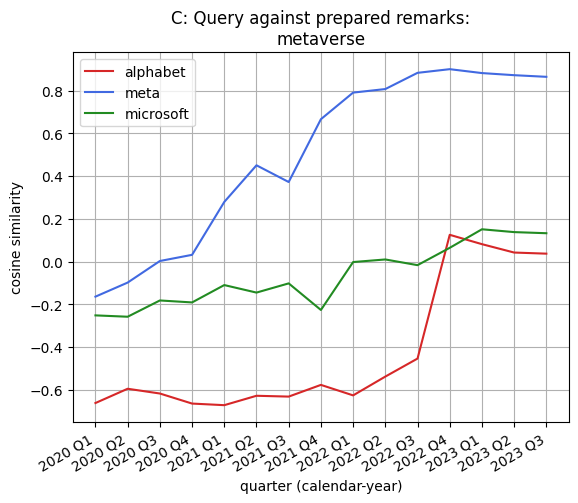

In [32]:
# --------------------#
#  GENERATES FIG 7C   #
# --------------------#

# Plot the trend of this query on the metaverse.
query_prepared_remarks('metaverse', 'C')

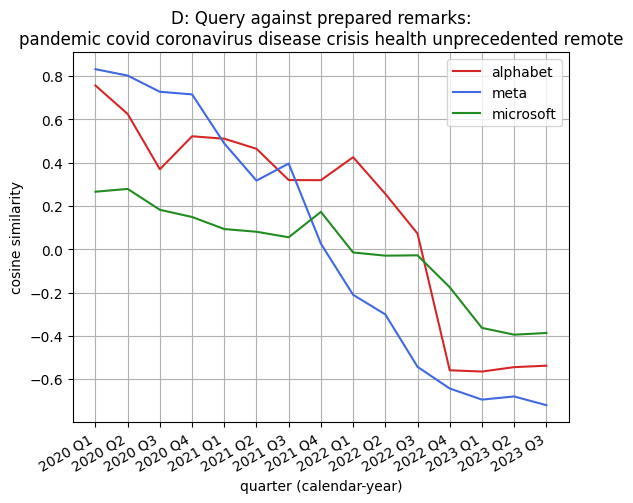

In [33]:
# --------------------#
#  GENERATES FIG 7D   #
# --------------------#

# Plot the trend of this query on COVID-19.
query_prepared_remarks('pandemic covid coronavirus disease crisis health unprecedented remote', 'D')

## LDA on Q&A

In [34]:
# Apply the same token cleaning function from before
# on all the Q&A data.

qna = []
for row in alphabet['q&a']:
  for q, a in row:
    qna.append(clean_tokens(f'{q} {a}'))
for row in meta['q&a']:
  for q, a in row:
    qna.append(clean_tokens(f'{q} {a}'))
for row in ms['q&a']:
  for q, a in row:
    qna.append(clean_tokens(f'{q} {a}'))
len(qna)

390

### Fig 4C, 4D

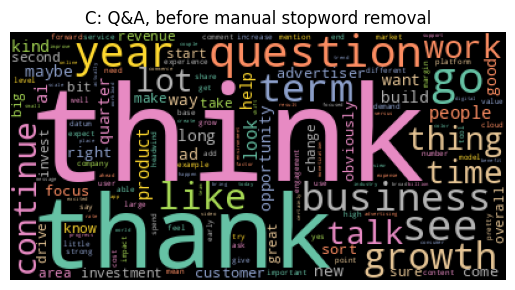

In [35]:
# --------------------#
#  GENERATES FIG 4C   #
# --------------------#

# Check the word cloud before any dataset specific stop word removal.
gen_wordcloud(qna, 'C: Q&A, before manual stopword removal')

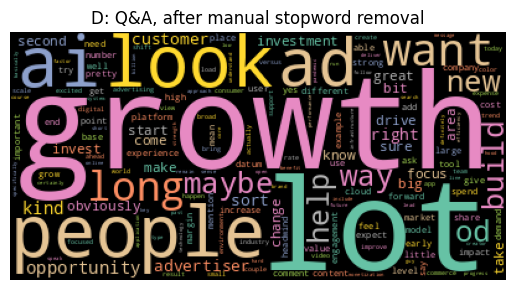

In [36]:
# --------------------#
#  GENERATES FIG 4D   #
# --------------------#

# Identified additional polite words that people say that should be removed.
# Also remove the financial stop words identified before.
polite_question_stopwords = ['think', 'thank', 'question', 'thing', 'like', 'term', 'overall', 'see', 'go', 'work', 'continue', 'time', 'talk']
for i in range(len(qna)):
  for w in financial_stopwords + polite_question_stopwords:
    qna[i] = qna[i].replace(w, '')

# Check the word cloud again now that all dataset specific stopwords have been removed.
gen_wordcloud(qna, 'D: Q&A, after manual stopword removal')

In [37]:
# Imports for LDA
from gensim.test.utils import common_texts
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary

In [38]:
# Apply filter to get rid of empty tokens after split
lda_dict = Dictionary([list(filter(None, x.split(' '))) for x in qna])
lda_corpus = [lda_dict.doc2bow(t) for t in [list(filter(None, x.split(' '))) for x in qna]]

# Run LDA
num_topics = 9  # large enough to capture a few topics, not too large to make interpretation unmanageable
lda_model = LdaMulticore(corpus=lda_corpus,
                          id2word=lda_dict,
                          num_topics=num_topics,
                          passes=100,  # enough to see essentially sparse document probability distributions
                          random_state=30224)

### Fig 8

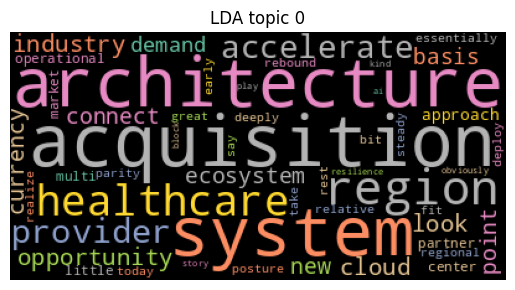

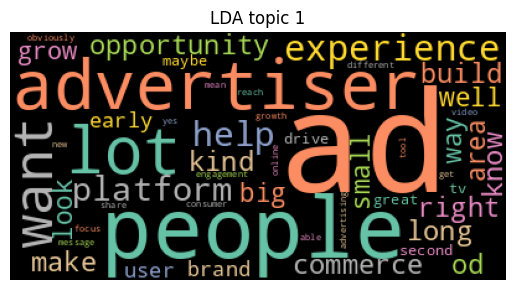

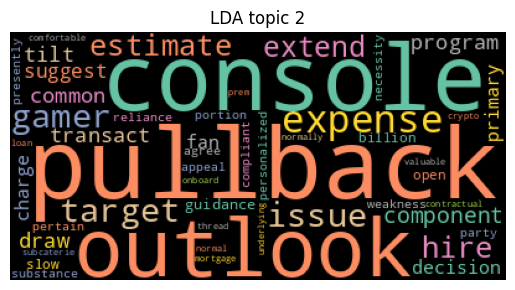

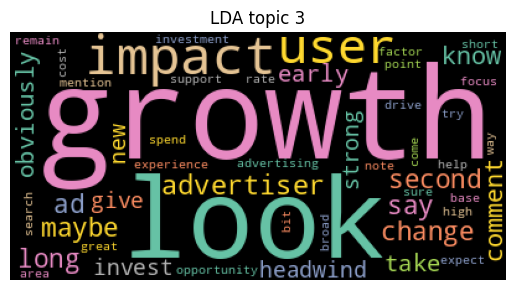

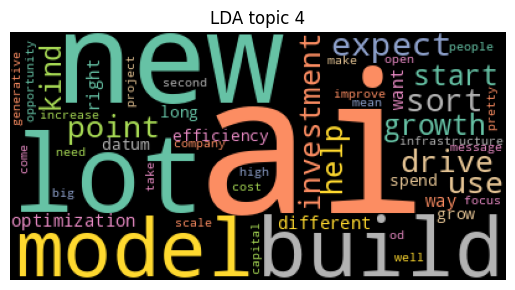

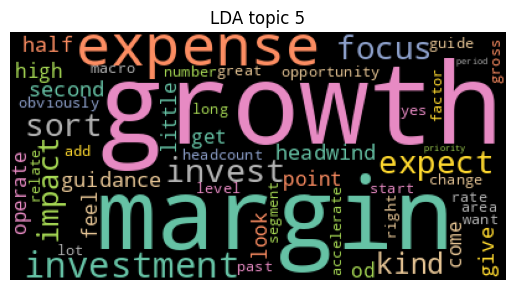

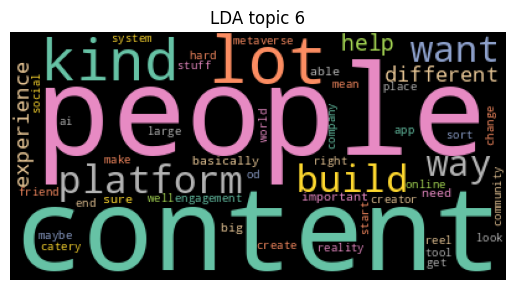

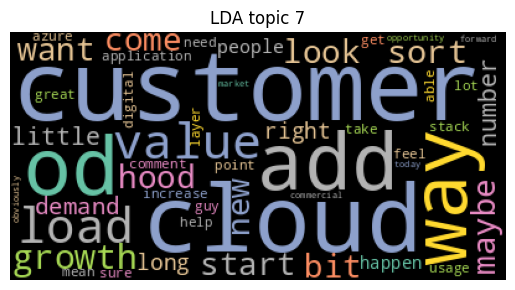

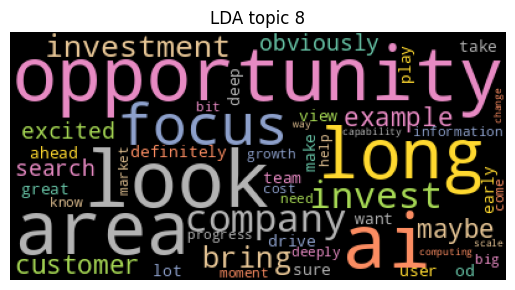

In [39]:
# --------------------#
#  GENERATES FIG 8    #
# --------------------#

# Visualize each topic at the word level using word clouds.
# Words are weighted according to the topic probability distribution.
for i, t in lda_model.show_topics(formatted=False, num_words=50):
  wc = wordcloud.WordCloud(stopwords=set(), collocations=False, colormap='Set2', random_state=30224)
  wc.generate_from_frequencies(frequencies={x:y for x, y in t})
  plt.title(f'LDA topic {i}')
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

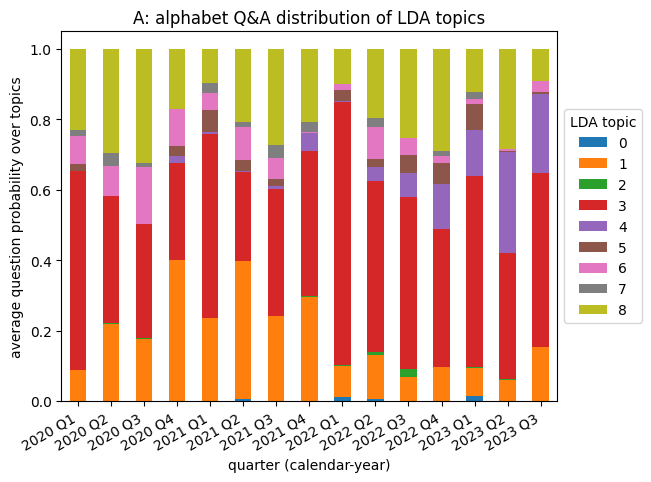

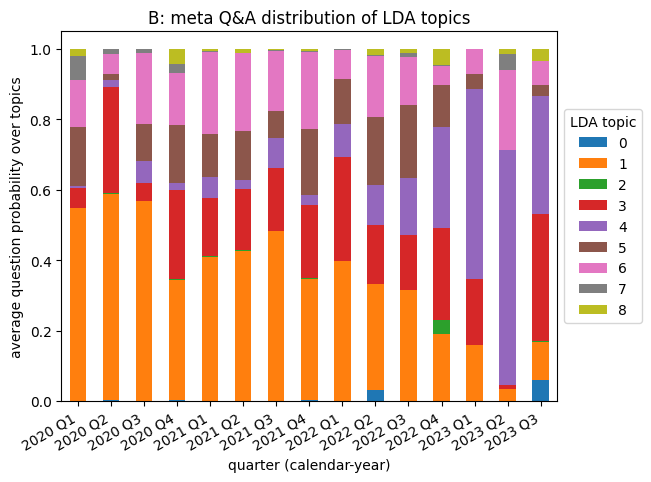

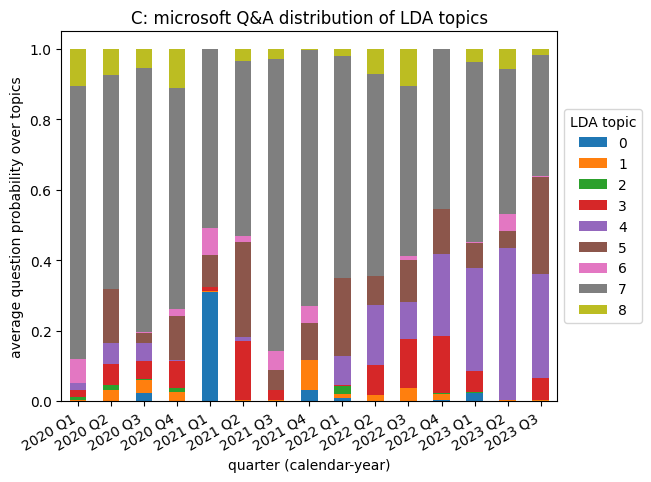

In [40]:
# --------------------#
#  GENERATES FIG 9    #
# --------------------#

# Figure out the number of calls per each call to unstack all the documents
# and attribute them properly to the right calls.
num_q_per_call = []
num_q_per_call.extend(alphabet.apply(lambda x: len(x['q']), axis=1))
num_q_per_call.extend(meta.apply(lambda x: len(x['q']), axis=1))
num_q_per_call.extend(ms.apply(lambda x: len(x['q']), axis=1))

topics_over_calls = np.zeros([45, num_topics])
i = 0  # counts question number within a call
j = 0  # counts which call we're on
for l in lda_corpus:
  # Divide each question's probability distribution by the number of questions
  # in that call to get an average.
  topics_over_calls[j] += np.asarray([p for i, p in lda_model.get_document_topics(l, minimum_probability=0)]) / num_q_per_call[j]

  # Increment counters
  i += 1
  if i >= num_q_per_call[j]:
    i = 0
    j += 1

# Visualize average topic distribution over calls
for i in range(3):
  pd.DataFrame(topics_over_calls[i*15:(i+1)*15], index=alphabet.index).plot(
      kind='bar', stacked=True,
      title=f'{["A", "B", "C"][i]}: {company_names_ordered[i]} Q&A distribution of LDA topics')
  plt.xlabel('quarter (calendar-year)')
  plt.ylabel('average question probability over topics')
  plt.xticks(rotation=30, ha='right')
  plt.legend(title='LDA topic', loc='center left', bbox_to_anchor=(1, 0.5))

# (end)

End of notebook.